In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import urllib
import re
from tqdm import tqdm 
%matplotlib inline
import sys
import seaborn as sns

sys.path.append('../code/')
from utils import *
from etl import *
import warnings
warnings.simplefilter('ignore')


### Connect to the database

In [2]:
database_config = load_config('../misc/database_config.yaml')[0]
    
engine = get_engine(database_config)

### Run ETL

In [3]:
!python3 -W ignore ../code/etl.py

transactions
users
fraudsters
currency_details
countries


### Retrieve the data from database and process it. 

In [4]:
df_transactions = get_transactions(engine)

df_users = get_users(engine, df_transactions)

### Data exploration

### Missing features

In [5]:
df_transactions.isna().sum(axis=0)

currency                      0
amount                        0
state                         0
created_date                  0
merchant_category        465586
merchant_country         205596
entry_method                  0
user_id                       0
type                          0
source                        0
id                            0
amount_usd                53323
merchant_country_name    209550
is_crypto                     0
exponent                      0
is_fraudster                  0
dtype: int64

### Impute missing amount_usd with an API

In [6]:
df_transactions = fill_missing_amount_usd(df_transactions)

### Visualization

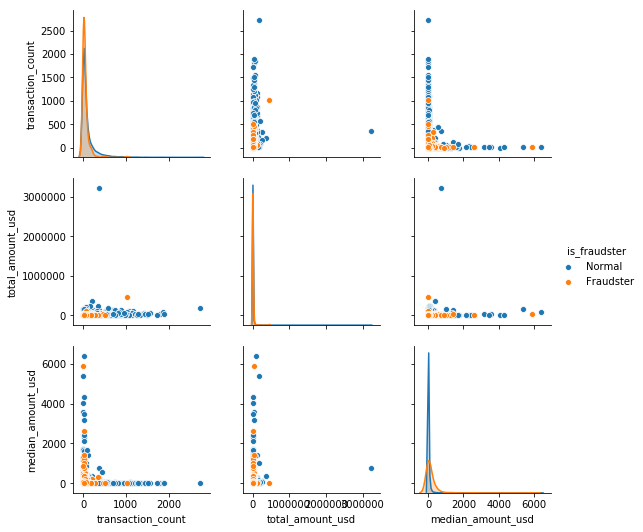

In [7]:
df_users_no_na = df_users[~df_users['is_fraudster'].isna()].dropna()
df_users_no_na.loc[:, 'is_fraudster'] = df_users_no_na.replace({False:'Normal',True:'Fraudster'})
sns.pairplot(df_users_no_na[['transaction_count', 'total_amount_usd', 'is_fraudster', 'state',
                            'median_amount_usd']], hue='is_fraudster',
            dropna=True)



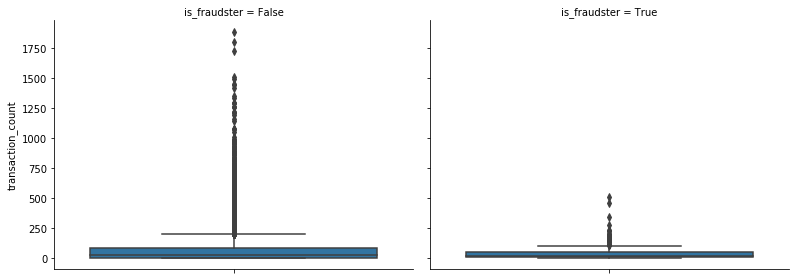

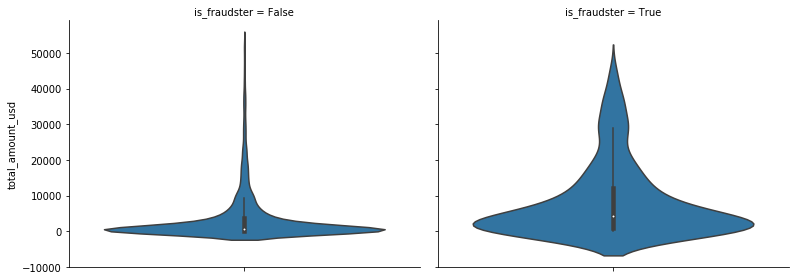

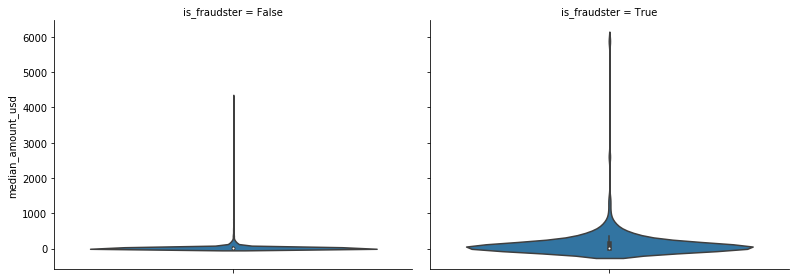

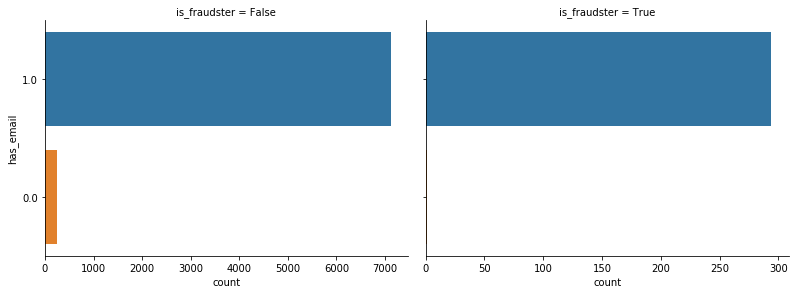

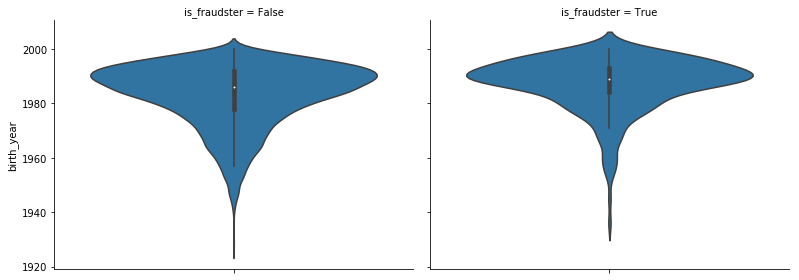

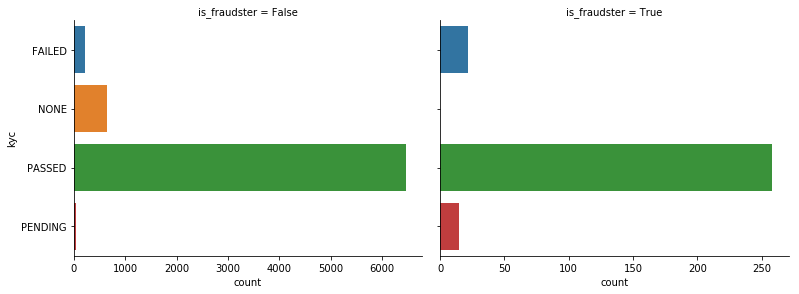

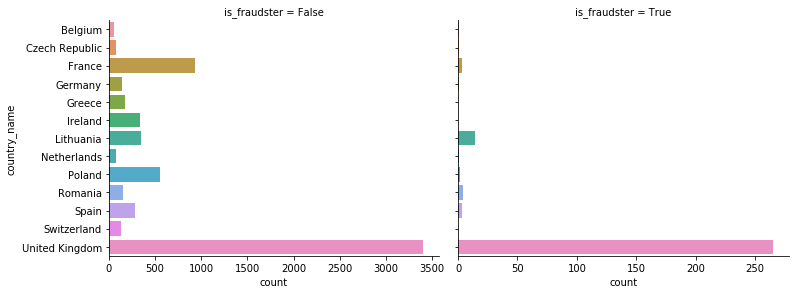

In [8]:
columns = [ ('transaction_count', 'box'), ('total_amount_usd', 'violin'),
           ('median_amount_usd', 'violin'), ('has_email', 'count'), ('birth_year', 'violin'), ('kyc', 'count'), 
           ('country_name', 'count')]
## Remove above 99th quantile of USD_TOTAL_AMOUNT
quantile_99th = df_users["total_amount_usd"].quantile(0.99)

df_users_wo_outliers = df_users[df_users['total_amount_usd'] < quantile_99th]

for column, plot_kind in columns:
    users_by_column = df_users_wo_outliers[['id', column]].groupby([column]).count()\
                            .unstack()['id'].replace(np.nan, 0).sort_values(ascending=False)
    top_ten_cols = None
    if plot_kind == 'count':
        df_fraudster_col = df_users_wo_outliers[df_users_wo_outliers['is_fraudster']==True][column].value_counts().sort_values(ascending=False)
        df_normal_col = df_users_wo_outliers[df_users_wo_outliers['is_fraudster']==False][column].value_counts().sort_values(ascending=False)
        top_ten_cols = df_fraudster_col.index[:10].union(df_normal_col.index[:10])
    
    
    g = sns.catplot(y=column,
             col="is_fraudster", 
             data=df_users_wo_outliers, kind=plot_kind,
             dodge=True,
             order=top_ten_cols,
             sharex=False if plot_kind=='count' else True,
             orient='v',
             height=4, aspect=1.4);
    
    #g.set_xticklabels(rotation=40)

    plt.show()


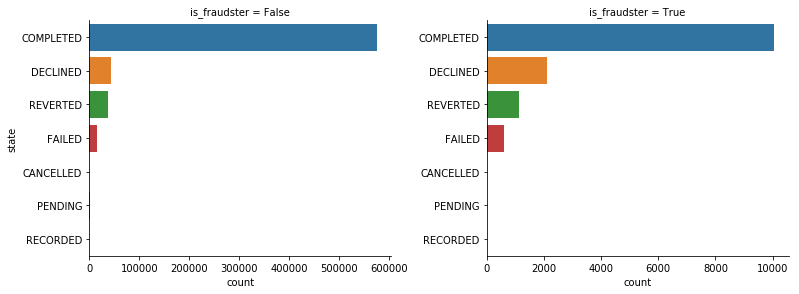

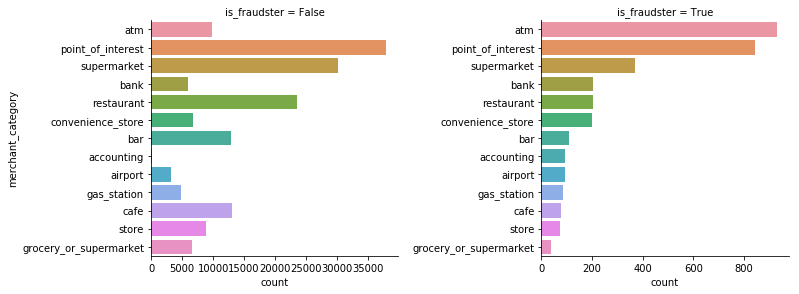

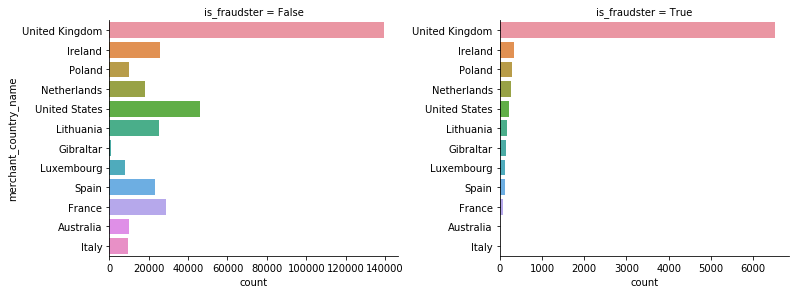

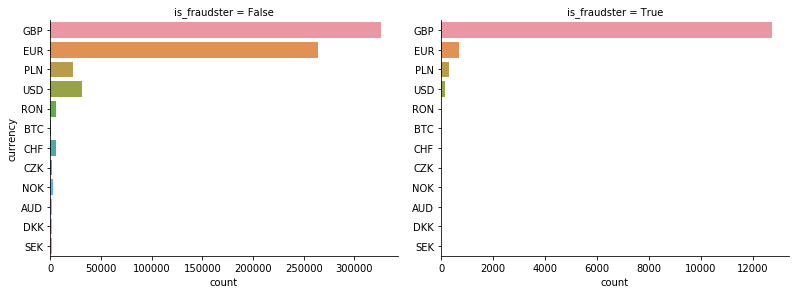

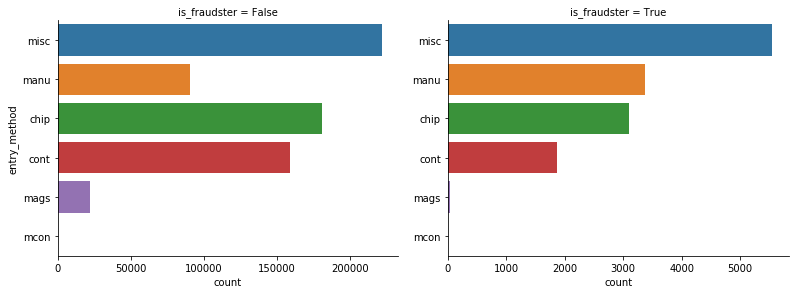

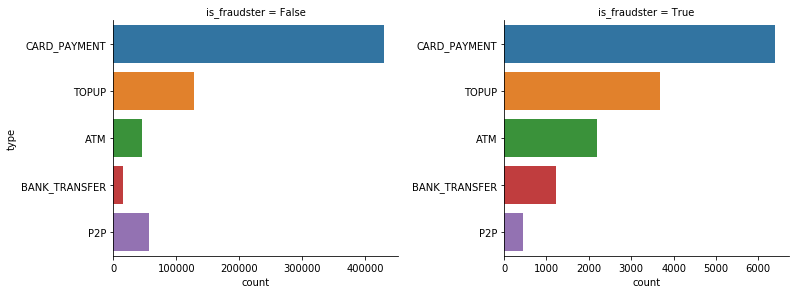

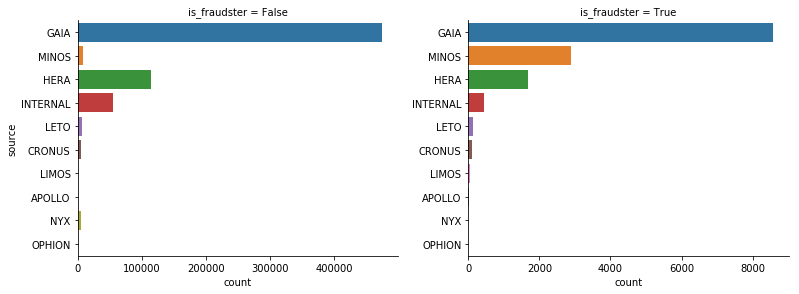

In [9]:
columns = ['state', 'merchant_category', 'merchant_country_name', 'currency', 'entry_method', 'type', 'source']

for column in columns:
    users_by_column = df_transactions[['id', column]].groupby([column]).count()\
                            .unstack()['id'].replace(np.nan, 0).sort_values(ascending=False)
    top_ten_cols = None
    df_fraudster_col = df_transactions[df_transactions['is_fraudster']==True][column].value_counts().sort_values(ascending=False)
    df_normal_col = df_transactions[df_transactions['is_fraudster']==False][column].value_counts().sort_values(ascending=False)
    top_ten_cols = df_fraudster_col.index[:10].union(df_normal_col.index[:10], sort=False)
   
    g = sns.catplot(y=column,
             col="is_fraudster", 
             data=df_transactions, kind='count',
             dodge=True,
             order=top_ten_cols,
             sharex=False,
             sharey=False,
             orient='v',
             height=4, aspect=1.4);
    plt.show()

if False:
    for column in columns:
        transactions_by_column = df_transactions[['id', column]].groupby([column]).count()\
                                .unstack()['id'].replace(np.nan, 0).sort_values(ascending=False)

        fraudster_by_column = df_transactions[['id', 'is_fraudster', column]].groupby([column, 'is_fraudster']).count()\
                                .unstack()["id"].replace(np.nan, 0)
        fig, axes = plt.subplots(1, 2)

        fraudster_by_column_pos = fraudster_by_column.loc[:, False].sort_values(ascending=False)
        fraudster_by_column_pos = merge_small_columns(fraudster_by_column_pos, 0.01)

        fraudster_by_column_pos.plot.pie(ax=axes[0], figsize=(20, 20), autopct='%1.2f%%', pctdistance=0.8, labeldistance=1.1)

        fraudster_by_column_neg = fraudster_by_column.loc[:, True].sort_values(ascending=False)
        fraudster_by_column_neg = merge_small_columns(fraudster_by_column_neg, 0.01)

        fraudster_by_column_neg.plot.pie(ax=axes[1], figsize=(20, 20), autopct='%1.2f%%', pctdistance=0.8, labeldistance=1.2)

        [t.set_yticklabels(t.get_yticklabels(), rotation=90)  for t in axes]

        axes[0].set_title('Normal user')
        axes[1].set_title('Fraudster')
        axes[0].set_ylabel(None)
        axes[1].set_ylabel(None)
        fig.suptitle('Chart for ' + column)
        fig.subplots_adjust(top=1.4)
        plt.show()

### Preliminary observations

There are very few fraudsters (238), which makes fraud detection task difficult.

Fraudsters tend to heavily use GBP (91% of all transactions), while normal users tend to use both GBP (47%) and EUR (40%) in their transactions. Also they are mainly from UK, whereas normal users are more diverse in terms of the country where they are from.


Fraudsters also tend to do bigger amount of transactions than normal users.

Source seems interesting as well. MINOS is around 1.24% of all transactions in normal users. It is over 20% for fraudsters.  

However these findings may not be conclusive and representative as we have very few positive,namely Fraudster, samples (298)

### Feature engineering

As we observed that currency and merchant_country seems to be considerably different in fraudsters, it may be wise to create features that describes the distribution of a user's currrency in their transactions. Likewise, we can also include the merchant country as one-hot encoding vector.

Overall, the following features are derived:


~~I first retrieved the currency rates from 2 websites, that gives me rates from all the currencies to USD in order to come up with a same unit for each transaction. Then I used USD currency as a reference for each transaction's amount. (AMOUNT_USD was not present in the transactions table despite it is described in the README.md)~~ (I reported this to HR guys, they uploaded new transaction table with amount_usd. However, my methods fetching the currency rates from the APIs are still present for imputting missing amount_usd values.)

**MEDIAN_AMOUNT_USD**: Median amount among a user's transactions 

**TOTAL_AMOUNT_USD**: Total amount of a user's transactions

**TRANSACTION_COUNT**: Number of a user's transactions

**MEAN_TRANSACTION_PERIOD**: This is average time difference between two transaction of a user. 

**CURRENCY[]**: A vector that sums up to 1. Each dimension represents the probability that a user is made transaction with a given currency.

**MERCHANT_COUNTRY[]**: A vector that sums up to 1. Each dimension represents the probability that a user is made transaction to a given merchant country.

**SOURCE[]**: A vector that sums up to 1. Each dimension represents the probability that a user is made transaction from a given source.

**STATE[] (from transactions table)**: A vector that sums up to 1. Each dimension represents the probability that a user's transaction state is the corresponding state. 

I did not include **STATE** variable from df_users as it is 100% correlated with IS_FRAUDSTER. This led me to believe that they are indeed created from each other. If I include it to my model, I get 100% accuracy in the test set. So, I believe that you would remove it but you just forgot. In addition, my model is intended to take an action and change the state variable. Therefore, it wouldn't make sense to use my future output as my input. 


For one-hot encoding vectors, I filtered dimensions by choosing only the features that consists more than 0.1% of transactions. As an example, Grenada will not be included to MERCHANT_COUNTRY vector as it is only present in 33 transactions ( <0.0001%), as these features have very low variance and will probably ineffective in prediction. 


## Create and load features into database

In [10]:
!python3 -W ignore ../code/features.py

### Retrieving features from csv

In [11]:
processed_dataset = pd.read_csv('../data/processed_dataset.csv').set_index('user_id')
processed_labels = pd.read_csv('../data/processed_labels.csv', header=None).set_index(0).loc[:, 1]

### Retrieve features from database

In [12]:
processed_dataset, processed_labels = get_features(engine)

### Model training and evaluation

I run XGBClassifier for this challenge. The reason is that it handles missing features, feature selection and regularization for myself. Additionally, it usually performs well in structured data. 

In order to evaluate the model, I initially split the dataset (stratified) into train (75%) and test sets (25%) . Afterwards, I did hyperparameter tuning with stratified kfold cross validation where `n_splits=3` 

After hyperparameter tuning with `Randomized Grid Search`, I used the hold out test set to evaluate the performance of the trained optimal model. 

As classes are unbalanced in the dataset due to the nature of the problem, I used F1 score and Matthews correlation coefficient that takes both false negatives and false positives into account. Therefore, metrics are appropriate for this domain, where the classes are highly unbalanced.

I repeated the aforementioned procedure **3 times** and evaluated the means and standard deviations of the scores.


Matthews correlation coefficient turned out to be around 0.76±0.03 which is actually much better than a poor model :). 

### Discussion

We could make the model more advanced by using stacking. Sometimes, it improves the performance. However, this is the final week at my university, so I don't have time to do this. ( I can do more analysis after next week if you'd like me to do)

One **assumption** I made is that the data does not depend on time (stationarity). Unfortunately, I didn't get any evidence that proves or rejects this assumption during my analysis.

### Obtain 3 XGB Models with hyperparameter tuning using different train test splits


In [13]:
from train import train_xgb_model
from sklearn.model_selection import train_test_split
random_states = [42, 52, 62]
scores = []

samples_with_labels = ~processed_labels.isna()
processed_dataset = processed_dataset[samples_with_labels]
processed_labels = processed_labels[samples_with_labels]

for random_state in random_states:
    
    train_set, test_set, train_labels, test_labels = train_test_split(processed_dataset, processed_labels, test_size=0.25,
                                                                 stratify=processed_labels, random_state=random_state)
    clf = train_xgb_model(train_set, train_labels)
    scores.append(get_metric_results(clf, test_set, test_labels))


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   20.6s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:   31.6s finished


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   19.4s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:   30.2s finished


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   19.5s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:   30.6s finished


### Evaluate the performance using relevant metrics

Confusion matrix, without normalization


,metric,score
0,avg_precision,0.84±0.02
1,f1_score,0.77±0.03
2,matthews,0.76±0.03
3,mse,0.05±0.01
4,roc_auc,0.98±0.01


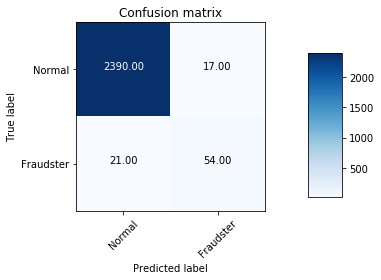

In [14]:
from utils import * 
from sklearn.metrics import confusion_matrix
fig = plt.figure()
plot_confusion_matrix(fig, confusion_matrix(test_labels, clf.predict(test_set)), classes=['Normal', 'Fraudster'])
df_scores = pd.DataFrame(scores)
df_scores = pd.concat([df_scores.agg(lambda x: str(round(x.mean(), 2)) + '±' + str(round(x.std(), 2)))], axis=0)
df_scores = pd.DataFrame({'metric': df_scores.index, 'score': df_scores.values})

df_scores

### Train a model and save it to artifacts/model.pkl

In [15]:
!python3 -W ignore ../code/train.py

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[CV] subsample=0.9, silent=False, scale_pos_weight=1, reg_lambda=100.0, n_estimators=150, min_child_weight=0.5, max_depth=15, learning_rate=0.01, gamma=1.0, colsample_bytree=0.8, colsample_bylevel=0.7 
[CV] subsample=0.9, silent=False, scale_pos_weight=1, reg_lambda=100.0, n_estimators=150, min_child_weight=0.5, max_depth=15, learning_rate=0.01, gamma=1.0, colsample_bytree=0.8, colsample_bylevel=0.7 
[CV] subsample=0.7, silent=False, scale_pos_weight=1, reg_lambda=10.0, n_estimators=100, min_child_weight=1.0, max_depth=20, learning_rate=0.01, gamma=0.25, colsample_bytree=0.9, colsample_bylevel=0.7 
[CV] subsample=0.9, silent=False, scale_pos_weight=1, reg_lambda=100.0, n_estimators=150, min_child_weight=0.5, max_depth=15, learning_rate=0.01, gamma=1.0, colsample_bytree=0.8, colsample_bylevel=0.7 
[CV] subsample=0.7, silent=False, scale_pos_weight=1,

[CV] subsample=0.5, silent=False, scale_pos_weight=4, reg_lambda=1.0, n_estimators=100, min_child_weight=3.0, max_depth=20, learning_rate=0, gamma=1.0, colsample_bytree=0.4, colsample_bylevel=0.8 
[CV] subsample=0.6, silent=False, scale_pos_weight=2, reg_lambda=50.0, n_estimators=70, min_child_weight=7.0, max_depth=15, learning_rate=0, gamma=0.5, colsample_bytree=0.7, colsample_bylevel=0.9 
/home/ibrahim/miniconda3/envs/dta_pred/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[CV]  subsample=0.6, silent=False, scale_pos_weight=2, reg_lambda=50.0, n_estimators=70, min_child_weight=7.0, max_depth=15, learning_rate=0, gamma=0.5, colsample_bytree=0.7, colsample_bylevel=0.9, total=   1.1s
[CV] subsample=0.6, silent=False, scale_pos_weight=2, reg_lambda=50.0, n_estimators=70, min_child_weight=7.0, max_depth=15, learning_rate=0, ga

[CV]  subsample=1.0, silent=False, scale_pos_weight=4, reg_lambda=50.0, n_estimators=70, min_child_weight=10.0, max_depth=10, learning_rate=0.001, gamma=0, colsample_bytree=1.0, colsample_bylevel=0.6, total=   1.1s
[CV]  subsample=1.0, silent=False, scale_pos_weight=1, reg_lambda=5.0, n_estimators=100, min_child_weight=1.0, max_depth=10, learning_rate=0, gamma=0, colsample_bytree=0.8, colsample_bylevel=0.6, total=   1.7s
[CV] subsample=1.0, silent=False, scale_pos_weight=4, reg_lambda=50.0, n_estimators=70, min_child_weight=10.0, max_depth=10, learning_rate=0.001, gamma=0, colsample_bytree=1.0, colsample_bylevel=0.6 
[CV] subsample=1.0, silent=False, scale_pos_weight=2, reg_lambda=0.1, n_estimators=70, min_child_weight=7.0, max_depth=10, learning_rate=0.1, gamma=0, colsample_bytree=0.4, colsample_bylevel=0.5 
[CV] subsample=1.0, silent=False, scale_pos_weight=2, reg_lambda=0.1, n_estimators=70, min_child_weight=7.0, max_depth=10, learning_rate=0.1, gamma=0, colsample_bytree=0.4, colsam

[CV]  subsample=1.0, silent=False, scale_pos_weight=1, reg_lambda=50.0, n_estimators=150, min_child_weight=3.0, max_depth=15, learning_rate=0, gamma=0, colsample_bytree=0.7, colsample_bylevel=0.7, total=   1.5s
[CV] subsample=0.9, silent=False, scale_pos_weight=4, reg_lambda=0.1, n_estimators=70, min_child_weight=1.0, max_depth=20, learning_rate=0.01, gamma=0, colsample_bytree=0.9, colsample_bylevel=0.4 
/home/ibrahim/miniconda3/envs/dta_pred/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[CV]  subsample=0.8, silent=False, scale_pos_weight=2, reg_lambda=10.0, n_estimators=100, min_child_weight=3.0, max_depth=15, learning_rate=0, gamma=0.25, colsample_bytree=1.0, colsample_bylevel=0.5, total=   1.5s
/home/ibrahim/miniconda3/envs/dta_pred/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarni

[CV]  subsample=0.8, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=50.0, n_estimators=150, min_child_weight=3.0, max_depth=10, learning_rate=0.001, gamma=1.0, colsample_bytree=0.5, colsample_bylevel=0.7, total=   2.7s
[CV]  subsample=0.9, silent=False, scale_pos_weight=2, reg_lambda=5.0, n_estimators=70, min_child_weight=7.0, max_depth=20, learning_rate=0.01, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.7, total=   0.9s
[CV] subsample=0.7, silent=False, scale_pos_weight=1, reg_lambda=1.0, n_estimators=100, min_child_weight=10.0, max_depth=10, learning_rate=0.001, gamma=1.0, colsample_bytree=0.4, colsample_bylevel=1.0 
[CV] subsample=0.5, silent=False, scale_pos_weight=2, reg_lambda=100.0, n_estimators=70, min_child_weight=7.0, max_depth=15, learning_rate=0.01, gamma=0.5, colsample_bytree=0.7, colsample_bylevel=0.7 
[CV]  subsample=0.9, silent=False, scale_pos_weight=2, reg_lambda=5.0, n_estimators=70, min_child_weight=7.0, max_depth=20, learning_rate=0.01, gamma=0

[CV]  subsample=0.5, silent=False, scale_pos_weight=2, reg_lambda=100.0, n_estimators=150, min_child_weight=5.0, max_depth=6, learning_rate=0.1, gamma=0.25, colsample_bytree=0.4, colsample_bylevel=0.4, total=   0.9s
[CV] subsample=0.6, silent=False, scale_pos_weight=4, reg_lambda=0.1, n_estimators=150, min_child_weight=10.0, max_depth=10, learning_rate=0, gamma=0.5, colsample_bytree=1.0, colsample_bylevel=0.6 
[CV]  subsample=1.0, silent=False, scale_pos_weight=4, reg_lambda=100.0, n_estimators=70, min_child_weight=3.0, max_depth=15, learning_rate=0.2, gamma=1.0, colsample_bytree=0.9, colsample_bylevel=1.0, total=   2.8s
[CV] subsample=0.6, silent=False, scale_pos_weight=4, reg_lambda=0.1, n_estimators=150, min_child_weight=10.0, max_depth=10, learning_rate=0, gamma=0.5, colsample_bytree=1.0, colsample_bylevel=0.6 
[CV]  subsample=1.0, silent=False, scale_pos_weight=4, reg_lambda=100.0, n_estimators=70, min_child_weight=3.0, max_depth=15, learning_rate=0.2, gamma=1.0, colsample_bytree=

[CV]  subsample=0.8, silent=False, scale_pos_weight=4, reg_lambda=50.0, n_estimators=70, min_child_weight=10.0, max_depth=20, learning_rate=0.1, gamma=0.25, colsample_bytree=0.6, colsample_bylevel=1.0, total=   1.3s
[CV] subsample=0.5, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=0.1, n_estimators=150, min_child_weight=0.5, max_depth=6, learning_rate=0.1, gamma=1.0, colsample_bytree=0.4, colsample_bylevel=0.9 
[CV]  subsample=0.6, silent=False, scale_pos_weight=4, reg_lambda=0.1, n_estimators=150, min_child_weight=10.0, max_depth=10, learning_rate=0, gamma=0.5, colsample_bytree=1.0, colsample_bylevel=0.6, total=   3.8s
[CV] subsample=0.5, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=0.1, n_estimators=150, min_child_weight=0.5, max_depth=6, learning_rate=0.1, gamma=1.0, colsample_bytree=0.4, colsample_bylevel=0.9 
[CV]  subsample=0.7, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=50.0, n_estimators=70, min_child_weight=10.0, max_depth=6,

[CV]  subsample=0.7, silent=False, scale_pos_weight=4, reg_lambda=1.0, n_estimators=70, min_child_weight=0.5, max_depth=6, learning_rate=0.01, gamma=0, colsample_bytree=0.6, colsample_bylevel=1.0, total=   1.6s
[CV] subsample=0.5, silent=False, scale_pos_weight=1, reg_lambda=100.0, n_estimators=150, min_child_weight=0.5, max_depth=15, learning_rate=3, gamma=0.5, colsample_bytree=1.0, colsample_bylevel=0.5 
[CV]  subsample=0.7, silent=False, scale_pos_weight=4, reg_lambda=1.0, n_estimators=70, min_child_weight=0.5, max_depth=6, learning_rate=0.01, gamma=0, colsample_bytree=0.6, colsample_bylevel=1.0, total=   1.6s
[CV] subsample=0.8, silent=False, scale_pos_weight=1, reg_lambda=10.0, n_estimators=70, min_child_weight=1.0, max_depth=15, learning_rate=0.1, gamma=0.5, colsample_bytree=1.0, colsample_bylevel=0.5 
[CV]  subsample=0.9, silent=False, scale_pos_weight=1, reg_lambda=0.1, n_estimators=150, min_child_weight=1.0, max_depth=15, learning_rate=0.1, gamma=0, colsample_bytree=0.6, colsa

[CV]  subsample=0.6, silent=False, scale_pos_weight=4, reg_lambda=5.0, n_estimators=100, min_child_weight=0.5, max_depth=15, learning_rate=0.1, gamma=0.5, colsample_bytree=1.0, colsample_bylevel=0.5, total=   2.7s
[CV] subsample=1.0, silent=False, scale_pos_weight=2, reg_lambda=1.0, n_estimators=150, min_child_weight=1.0, max_depth=20, learning_rate=0.001, gamma=0, colsample_bytree=0.8, colsample_bylevel=0.5 
[CV]  subsample=0.5, silent=False, scale_pos_weight=4, reg_lambda=1.0, n_estimators=150, min_child_weight=1.0, max_depth=15, learning_rate=0.001, gamma=0.25, colsample_bytree=0.4, colsample_bylevel=0.4, total=   1.6s
[CV]  subsample=0.5, silent=False, scale_pos_weight=4, reg_lambda=1.0, n_estimators=150, min_child_weight=1.0, max_depth=15, learning_rate=0.001, gamma=0.25, colsample_bytree=0.4, colsample_bylevel=0.4, total=   1.7s
[CV] subsample=1.0, silent=False, scale_pos_weight=2, reg_lambda=1.0, n_estimators=150, min_child_weight=1.0, max_depth=20, learning_rate=0.001, gamma=0,

[CV] subsample=0.5, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=5.0, n_estimators=70, min_child_weight=3.0, max_depth=6, learning_rate=3, gamma=0.5, colsample_bytree=0.8, colsample_bylevel=0.7 
[CV]  subsample=0.5, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=5.0, n_estimators=70, min_child_weight=3.0, max_depth=6, learning_rate=3, gamma=0.5, colsample_bytree=0.8, colsample_bylevel=0.7, total=   0.4s
[CV] subsample=0.7, silent=False, scale_pos_weight=2, reg_lambda=10.0, n_estimators=150, min_child_weight=7.0, max_depth=10, learning_rate=0.001, gamma=0.5, colsample_bytree=0.4, colsample_bylevel=0.5 
[CV]  subsample=0.5, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=5.0, n_estimators=70, min_child_weight=3.0, max_depth=6, learning_rate=3, gamma=0.5, colsample_bytree=0.8, colsample_bylevel=0.7, total=   0.5s
[CV] subsample=0.7, silent=False, scale_pos_weight=2, reg_lambda=10.0, n_estimators=150, min_child_weight=7.0, max_depth=10, learnin

[CV]  subsample=1.0, silent=False, scale_pos_weight=2, reg_lambda=1.0, n_estimators=150, min_child_weight=0.5, max_depth=20, learning_rate=0, gamma=0.5, colsample_bytree=0.6, colsample_bylevel=0.6, total=   3.0s
[CV] subsample=0.8, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=0.1, n_estimators=100, min_child_weight=5.0, max_depth=6, learning_rate=3, gamma=0.5, colsample_bytree=0.5, colsample_bylevel=0.6 
[CV]  subsample=0.8, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=0.1, n_estimators=100, min_child_weight=5.0, max_depth=6, learning_rate=3, gamma=0.5, colsample_bytree=0.5, colsample_bylevel=0.6, total=   0.4s
[CV] subsample=0.8, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=0.1, n_estimators=100, min_child_weight=5.0, max_depth=6, learning_rate=3, gamma=0.5, colsample_bytree=0.5, colsample_bylevel=0.6 
[CV]  subsample=0.6, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=50.0, n_estimators=70, min_child_weight=1.0, max_de

[CV] subsample=0.8, silent=False, scale_pos_weight=2, reg_lambda=0.1, n_estimators=70, min_child_weight=1.0, max_depth=10, learning_rate=0.001, gamma=0.25, colsample_bytree=0.5, colsample_bylevel=0.8 
[CV] subsample=0.6, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=1.0, n_estimators=150, min_child_weight=0.5, max_depth=20, learning_rate=3, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.5 
[CV]  subsample=0.7, silent=False, scale_pos_weight=4, reg_lambda=50.0, n_estimators=150, min_child_weight=10.0, max_depth=15, learning_rate=0.2, gamma=0.25, colsample_bytree=0.4, colsample_bylevel=0.6, total=   1.3s
[CV] subsample=0.6, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=1.0, n_estimators=150, min_child_weight=0.5, max_depth=20, learning_rate=3, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.5 
[CV]  subsample=0.7, silent=False, scale_pos_weight=4, reg_lambda=50.0, n_estimators=150, min_child_weight=10.0, max_depth=15, learning_rate=0.2, gamma=0.25, 

[CV] subsample=0.5, silent=False, scale_pos_weight=2, reg_lambda=10.0, n_estimators=150, min_child_weight=5.0, max_depth=20, learning_rate=3, gamma=0, colsample_bytree=0.9, colsample_bylevel=0.5 
[CV]  subsample=0.6, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=50.0, n_estimators=70, min_child_weight=1.0, max_depth=15, learning_rate=0.2, gamma=0, colsample_bytree=0.5, colsample_bylevel=0.6, total=   1.3s
[CV]  subsample=1.0, silent=False, scale_pos_weight=1, reg_lambda=10.0, n_estimators=150, min_child_weight=5.0, max_depth=15, learning_rate=0.1, gamma=0, colsample_bytree=0.9, colsample_bylevel=0.4, total=   1.8s
[CV]  subsample=0.6, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=50.0, n_estimators=70, min_child_weight=1.0, max_depth=15, learning_rate=0.2, gamma=0, colsample_bytree=0.5, colsample_bylevel=0.6, total=   1.3s
[CV]  subsample=0.6, silent=False, scale_pos_weight=32.308724832214764, reg_lambda=50.0, n_estimators=70, min_child_weight=1.0, max_d

### Patrol.py

It may be wise to lock user when we are highly certain that the user is a fraudster. To do this, we may aim to
maximize our utility. I defined a cost that denotes the loss of company when we didn't lock a fraudster but only
alert the agent and another cost that denotes the loss of company when we locked a normal user despite that
they are innocent. Hereby, the algorithm determines the action based on the losses given by the company.

Costs can be updated from misc/patrol_config.yaml


As a summary here is the utilities

`action_costs = {
    'LOCK_USER': prob_being_normal * costs['cost_of_false_negative'],
    'ALERT_AGENT': prob_being_fraudster * costs['cost_of_false_negative'],
    'NONE': prob_being_fraudster * costs['cost_of_false_positive']
}`

The action with the minimum cost is gonna be returned from the patrol method.


In [16]:
from patrol import patrol

patrol('2707dd70-86d3-4823-ad0f-91a340bccb88')

'LOCK_USER'